Install ```AIF360``` with minimum requirements:

In [0]:
!pip install aif360

Install packages that we will use:

In [0]:
import aif360
import numpy as np
import matplotlib.pyplot as plt
import pickle

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions \
    import load_preproc_data_adult
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.metrics import ClassificationMetric
from aif360.datasets.adult_dataset import AdultDataset
from sklearn.preprocessing import StandardScaler
#from sklearn.linear_model import LogisticRegression

import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.utils.data as Data

# These 2 functions will help us save and load objects
path = "/content/drive/My Drive/Colab Notebooks/Ethics/"
def save_obj(obj, name ):
    with open(path+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [0]:
adult_dataset_orig = load_preproc_data_adult()

Define privileged and unprivileged groups:

In [0]:
# Assume privieleged group is the White Males
privileged_groups = [{'sex': 1, 'race': 1}]
unprivileged_groups = [{'sex': 1, 'race': 0}, {'sex': 0, 'race': 0}, {'sex': 0, 'race': 1}]

Visualise Adult data with respect to the taget label ('Income Binary'; >50k or <=50k) and the sensitive attributes (sex and race):

Male
white <=50k: 19670 	white >50k: 9065 	Total: 28735
nonwhite <=50k: 3062 	nonwhite >50k: 853 	Total: 3915
Female
white <=50k: 11485 	>white 50k: 1542 	Total: 13027
nonwhite <=50k: 2938 	>nonwhite 50k: 227 	Total: 3165

				Total: 48842


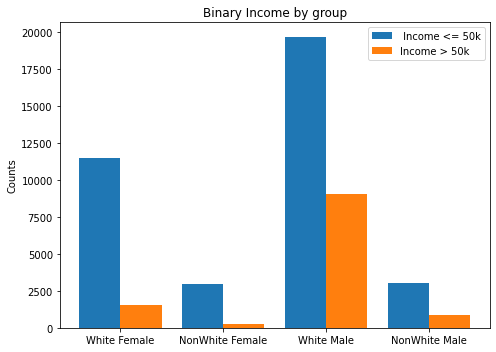

In [0]:
df = adult_dataset_orig.metadata['params']['df'].copy()
# Number of White Men with Income <=50 k
white_male_less_50k = sum(df[((df['sex'] == 1.0) & (df['race'] == 1.0))]['Income Binary'] == 0.0)

# Number of Nonwhite Men with Income <=50 k
nonwhite_male_less_50k = sum(df[((df['sex'] == 1.0) & (df['race'] == 0.0))]['Income Binary'] == 0.0)

# Number of white Men with Income >50 k
white_male_more_50k = sum(df[((df['sex'] == 1.0) & (df['race'] == 1.0))]['Income Binary'] == 1.0)

# Number of Nonwhite Men with Income >50 k
nonwhite_male_more_50k = sum(df[((df['sex'] == 1.0) & (df['race'] == 0.0))]['Income Binary'] == 1.0)

# Number of white Women with Income <=50 k
white_female_less_50k = sum(df[((df['sex'] == 0.0) & (df['race'] == 1.0))]['Income Binary'] == 0.0)

# Number of Nonwhite Women with Income <=50 k
nonwhite_female_less_50k = sum(df[((df['sex'] == 0.0) & (df['race'] == 0.0))]['Income Binary'] == 0.0)

# Number of white women with Income >50 k
white_female_more_50k = sum(df[((df['sex'] == 0.0) & (df['race'] == 1.0))]['Income Binary'] == 1.0)

# Number of Nonwhite women with Income >50 k
nonwhite_female_more_50k = sum(df[((df['sex'] == 0.0) & (df['race'] == 0.0))]['Income Binary'] == 1.0)

print('Male')
print('white <=50k:', white_male_less_50k,'\twhite >50k:', 
      white_male_more_50k, '\tTotal:', white_male_less_50k + white_male_more_50k)
print('nonwhite <=50k:', nonwhite_male_less_50k,'\tnonwhite >50k:', 
      nonwhite_male_more_50k, '\tTotal:', nonwhite_male_less_50k + nonwhite_male_more_50k)

print('Female')
print('white <=50k:', white_female_less_50k, '\t>white 50k:', 
      white_female_more_50k, '\tTotal:', white_female_less_50k + white_female_more_50k)
print('nonwhite <=50k:', nonwhite_female_less_50k, '\t>nonwhite 50k:', 
      nonwhite_female_more_50k, '\tTotal:', nonwhite_female_less_50k + nonwhite_female_more_50k)

print('\n\t\t\t\tTotal:', white_male_less_50k + white_male_more_50k + nonwhite_male_less_50k + \
      nonwhite_male_more_50k + white_female_less_50k + white_female_more_50k + nonwhite_female_less_50k + nonwhite_female_more_50k)
# Plot a bar graph:
labels = ['White Female', 'NonWhite Female','White Male', 'NonWhite Male']
less_50k = [white_female_less_50k,nonwhite_female_less_50k, white_male_less_50k, nonwhite_male_less_50k]
more_50k = [white_female_more_50k, nonwhite_female_more_50k, white_male_more_50k, nonwhite_male_more_50k]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(x - width/2, less_50k, width, label=' Income <= 50k')
rects2 = ax.bar(x + width/2, more_50k, width, label='Income > 50k')

ax.set_ylabel('Counts')
ax.set_title('Binary Income by group')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

Split Dataset into training and test data:

In [0]:
ad_train, ad_test = adult_dataset_orig.split([0.75], shuffle=True)

In [0]:
# Preprocess data
scale_orig = StandardScaler()

X_train = scale_orig.fit_transform(ad_train.features)
y_train = ad_train.labels.ravel()

X_test = scale_orig.transform(ad_test.features)
y_test = ad_test.labels.ravel()

Reweigh data:

In [0]:
labels = ad_train.labels.ravel()
features = ad_train.features[:,:2]
WEIGHTS = {}
# W_(y,a) = count(Y=y) * count(A=a) / (count(Y=y, A=a) * N)
# In total 8 unique weights
for Y in range(2):
    WEIGHTS[Y] = {}
    for A in [(0,0), (0,1), (1,0), (1,1)]:
        NY = sum(ad_train.labels.ravel() == Y)
        NA = sum((ad_train.features[:,0] == A[0]) & (ad_train.features[:,1] == A[1]))
        NYA = sum((ad_train.labels.ravel() == Y) & (ad_train.features[:,0] == A[0]) & (ad_train.features[:,1] == A[1]))
        WEIGHTS[Y][A] = {}
        WEIGHTS[Y][A] = (NY * NA / (NYA * ad_train.labels.shape[0]))

W = torch.zeros(ad_train.labels.shape[0])
for i in range(len(labels)):
    W[i] = WEIGHTS[labels[i]][(features[i,0], features[i,1])]

rw_train_dataset = Data.TensorDataset(torch.tensor(X_train).float(), 
                                      torch.Tensor(y_train).float(), 
                                      W.float())

Create a Logistic Regression class with pytorch:

In [0]:
class LogisticRegression_torch(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression_torch, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
BATCH_SIZE = 32
learning_rate = 0.0001

# Data Tensor
train_dataset = Data.TensorDataset(torch.tensor(X_train).float(), torch.Tensor(y_train).float())

if device == 0:
    num_workers = 2
else:
    num_workers = 0

# Data Loader
loader_train = Data.DataLoader(
    dataset=rw_train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, num_workers=num_workers)

In [0]:
from sklearn.metrics import confusion_matrix as CM
epochs = 4

metrics_rw = {}

lambdas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
lambdas = np.concatenate((np.array(lambdas), np.linspace(1, 100, num=150)))
for reg_lambda in lambdas:
    model = LogisticRegression_torch(X_train.shape[1], 1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
    print('Lambda:', reg_lambda,'\n')
    for epoch in range(epochs):
        train_loss = 0.0
        for i, (x, y, w) in enumerate(loader_train):
        # Converting inputs and labels to Variable

            inputs = Variable(x.to(device))
            labels = Variable(y.to(device))

            # Clear gradient buffers because we don't want any gradient 
            # from previous epoch to carry forward, dont want to cummulate gradients
            optimizer.zero_grad()

            # get output from the model, given the inputs
            outputs = model(inputs)

            # Regularization
            reg = 0
            for param in model.parameters():
                reg += 0.5 * (param ** 2).mean()
            
            # criterion
            criterion = torch.nn.BCELoss(weight=w, reduction='sum')
            # get loss for the predicted output
            loss = criterion(outputs.reshape(outputs.shape[0]), labels) + \
                reg_lambda * reg
            
                
            train_loss += loss.item()
            
            # get gradients w.r.t to parameters
            loss.backward()
            
            # update parameters
            optimizer.step()
        

        print('epoch [{}/{}], Training loss:{:.6f}'.format(
            epoch + 1, 
            epochs, 
            train_loss / len(loader_train.dataset)))
    with torch.no_grad():
        model.eval()
        out = model(Variable(torch.Tensor(X_test).to(device))).detach().cpu()
        pred = (out >= 0.5).int().numpy().squeeze()
    
    accuracy = sum((y_test == pred))/len(y_test)
    print('Accuracy: ', accuracy,'\n')

    test_pred = ad_test.copy()
    test_pred.labels = pred.reshape(-1,1)
    #White Men 
    white_male = ad_test.labels[((ad_test.features[:,1] == 1.0) & (ad_test.features[:,0] == 1.0))]
    white_male_pred = pred[((ad_test.features[:,1] == 1.0) & (ad_test.features[:,0] == 1.0))]
    #Nonwhite Men
    nonwhite_male = ad_test.labels[((ad_test.features[:,1] == 1.0) & (ad_test.features[:,0] == 0.0))]
    nonwhite_male_pred = pred[((ad_test.features[:,1] == 1.0) & (ad_test.features[:,0] == 0.0))]

    #White Female
    white_female = ad_test.labels[((ad_test.features[:,1] == 0.0) & (ad_test.features[:,0] == 1.0))]
    white_female_pred = pred[((ad_test.features[:,1] == 0.0) & (ad_test.features[:,0] == 1.0))]
    #Nonwhite Men
    nonwhite_female = ad_test.labels[((ad_test.features[:,1] == 0.0) & (ad_test.features[:,0] == 0.0))]
    nonwhite_female_pred = pred[((ad_test.features[:,1] == 0.0) & (ad_test.features[:,0] == 0.0))]
        
    metrics_rw[reg_lambda] = {}
    metrics_rw[reg_lambda]['accuracy'] = accuracy
    metrics_rw[reg_lambda]['privilaged'] = {}
    metrics_rw[reg_lambda]['unprivilaged'] = {}

    # GET TPR and TNR for each unique group
    tn, fp, fn, tp = CM(white_male, white_male_pred).ravel()
    metrics_rw[reg_lambda]['privilaged']['White Male'] =  (tp/(tp+fn), tn/(tn+fp))


    tn, fp, fn, tp = CM(nonwhite_male, nonwhite_male_pred).ravel()
    metrics_rw[reg_lambda]['unprivilaged']['Nonwhite Male'] = (tp/(tp+fn), tn/(tn+fp))


    tn, fp, fn, tp = CM(nonwhite_female, nonwhite_female_pred).ravel()
    metrics_rw[reg_lambda]['unprivilaged']['Nonwhite Female'] = (tp/(tp+fn), tn/(tn+fp))


    tn, fp, fn, tp = CM(white_female, white_female_pred).ravel()
    metrics_rw[reg_lambda]['unprivilaged']['White Female'] = (tp/(tp+fn), tn/(tn+fp))



Lambda: 0.0 

epoch [1/4], Training loss:0.563622
epoch [2/4], Training loss:0.481069
epoch [3/4], Training loss:0.460172
epoch [4/4], Training loss:0.452398
Accuracy:  0.7847842109573335 

Lambda: 1e-05 

epoch [1/4], Training loss:0.613272
epoch [2/4], Training loss:0.490675
epoch [3/4], Training loss:0.463506
epoch [4/4], Training loss:0.453964
Accuracy:  0.7856850380804193 

Lambda: 0.0001 

epoch [1/4], Training loss:0.571538
epoch [2/4], Training loss:0.483293
epoch [3/4], Training loss:0.460988
epoch [4/4], Training loss:0.452743
Accuracy:  0.7851936778314634 

Lambda: 0.001 

epoch [1/4], Training loss:0.548967
epoch [2/4], Training loss:0.477175
epoch [3/4], Training loss:0.458556
epoch [4/4], Training loss:0.451576
Accuracy:  0.7847842109573335 

Lambda: 0.01 

epoch [1/4], Training loss:0.576060
epoch [2/4], Training loss:0.483930
epoch [3/4], Training loss:0.461542
epoch [4/4], Training loss:0.453288
Accuracy:  0.7856850380804193 

Lambda: 0.1 

epoch [1/4], Training loss:0

In [0]:
save_obj(metrics_rw, 'adult_nonbinary_met')


Plot TPR and NPR for each sensitive class with respect to $\lambda$:




[(0.5, 1.0)]

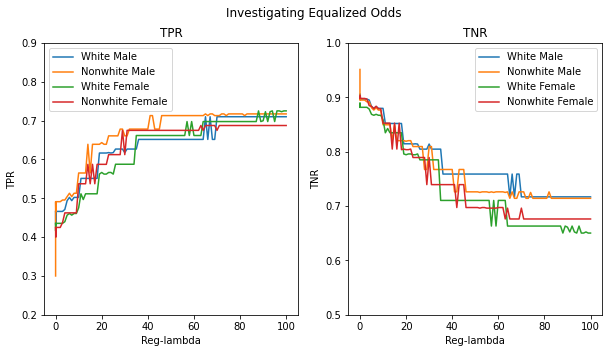

In [0]:
TPR_priv = []
TNR_priv = []

TPR_non_priv1 = []
TNR_non_priv1 = []
TPR_non_priv2 = []
TNR_non_priv2 = []
TPR_non_priv3 = []
TNR_non_priv3 = []
lambdas = []
for l in metrics_rw:
    lambdas.append(l)
    TPR_priv.append(metrics_rw[l]['privilaged']['White Male'][0])
    TNR_priv.append(metrics_rw[l]['privilaged']['White Male'][1])
    TPR_non_priv1.append(metrics_rw[l]['unprivilaged']['Nonwhite Male'][0])
    TNR_non_priv1.append(metrics_rw[l]['unprivilaged']['Nonwhite Male'][1])
    TPR_non_priv2.append(metrics_rw[l]['unprivilaged']['White Female'][0])
    TNR_non_priv2.append(metrics_rw[l]['unprivilaged']['White Female'][1])
    TPR_non_priv3.append(metrics_rw[l]['unprivilaged']['Nonwhite Female'][0])
    TNR_non_priv3.append(metrics_rw[l]['unprivilaged']['Nonwhite Female'][1])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Investigating Equalized Odds')
axs[0].plot(lambdas, TPR_priv)
axs[0].plot(lambdas, TPR_non_priv1)
axs[0].plot(lambdas, TPR_non_priv2)
axs[0].plot(lambdas, TPR_non_priv3)
axs[0].set_title('TPR')
axs[0].set(xlabel='Reg-lambda', ylabel='TPR')
axs[0].legend(['White Male', 'Nonwhite Male', 'White Female', 'Nonwhite Female'])
axs[0].set(ylim=(0.2,0.9))

axs[1].plot(lambdas, TNR_priv)
axs[1].plot(lambdas, TNR_non_priv1)
axs[1].plot(lambdas, TNR_non_priv2)
axs[1].plot(lambdas, TNR_non_priv3)
axs[1].set_title('TNR')
axs[1].set(xlabel='Reg-lambda', ylabel='TNR')
axs[1].legend(['White Male', 'Nonwhite Male', 'White Female', 'Nonwhite Female'])
axs[1].set(ylim=(0.5,1))

Plot accuracy with respect to $\lambda$:

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Reg-lambda')]

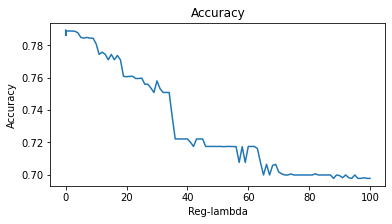

In [0]:
ACC  = []
for l in metrics_rw:
    ACC.append(metrics_rw[l]['accuracy'])


fig, axs = plt.subplots(1, 1, figsize=(6,3))
axs.plot(lambdas, ACC)
axs.set_title('Accuracy')
axs.set(xlabel='Reg-lambda', ylabel = 'Accuracy')